# Writing a Solver

Bluemira provides an interface to write a general solver that performs a setup, run, and teardown stage. Bluemira can run these solvers during design stages and TODO

To define a solver, inherit from `SolverABC` and implement the interface.
As an example, let's implement a solver to fit a gaussian curve to some noisy data using `scipy`, 
and return the coordinates of the fitted curve.

In [1]:
import enum
from typing import Any, Dict

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

from bluemira.base.solver import SolverABC, Task, RunMode

Let's generate some noisy (Gaussian) data to use in the example.

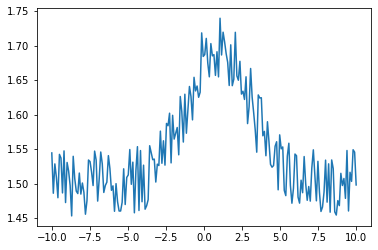

In [2]:
def gaussian(x, sigma, mu, vertical_offset):
    return (
        1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-1 / 2 * ((x - mu) / sigma) ** 2)
        + vertical_offset
    )


rng_seed = 101
rng = np.random.default_rng(rng_seed)
x_space = np.linspace(-10, 10, 200)
gauss_params = {
    "sigma": 2,
    "mu": 1,
    "vertical_offset": 1.5,
}
clean_gauss_data = gaussian(x_space, **gauss_params)
gauss_data = clean_gauss_data + rng.uniform(-0.05, 0.05, len(x_space))

plt.plot(x_space, gauss_data);

First we need to enumerate the ways to run our solver. 
Your new `Enum` should inhert from `solver.RunMode` and define the possible run modes for your solver.
Generally, your solver will always have a `RUN` mode.
Common examples of other run modes are `READ` and `MOCK`.

In [3]:
class GaussFitRunMode(RunMode):
    RUN = enum.auto()
    MOCK = enum.auto()

Next you must define a `Task` class for each of the setup, run, and teardown stages of the problem. 
Each task must define a method corresponding to each name in the enum (written in lowercase) we just defined. 
In this case, we've defined `RUN` and `MOCK` run modes, so we should define methods `run` and `mock` in at least one of our tasks. If a run mode is not defined for a given task, that stage is skipped; returning its input.

Each of the "run mode" methods should set the `result` property on the task.

In [4]:
class GaussFitSetup(Task):
    """
    Task to set up the gaussian fitting problem.

    This makes some estimates for the fitting parameters.
    """

    result = {
        "mu": 1,
        "sigma": 1,
        "vertical_offset": 0,
    }

    def __init__(self, params: Dict[str, Any]):
        super().__init__(params)
        self._x = params["x"]
        self._y = params["y"]

    def run(self):
        """
        Set up the fitting problem.
        """
        self.result = {
            "mu": self._estimate_mu(),
            "sigma": self._estimate_sigma(),
            "vertical_offset": self._estimate_vertical_offset(),
        }

    def _estimate_mu(self) -> float:
        """The x-value where y is at its maximum estimates the mean."""
        return self._x[np.argmax(self._y)]

    def _estimate_sigma(self) -> float:
        """Estimate x distance between the half heights and halve."""
        half_height = (np.max(self._y) + np.min(self._y)) / 2
        x_above_hh = self._x[self._y > half_height]
        return abs(x_above_hh[0] - x_above_hh[-1]) / 2

    def _estimate_vertical_offset(self) -> float:
        """The minimum value of y; only noise makes this not exact"""
        return np.min(self._y)


class GaussFitRun(Task):
    """
    Task to run the fitting algorithm.

    This implements a "run" and "mock" run mode. The "run" mode executes
    the fitting algorithm, the "mock" just outputs whatever initial
    guess was passed from the setup task.
    """

    result: Dict[str, Any]

    def __init__(self, params: Dict[str, Any]):
        super().__init__(params)

    def run(self, setup_result: Dict[str, float]):
        """Run the fit."""
        initial_guess = (
            setup_result["sigma"],
            setup_result["mu"],
            setup_result["vertical_offset"],
        )
        opt, _ = curve_fit(
            gaussian, self._params["x"], self._params["y"], p0=initial_guess
        )
        self.result = {
            "sigma": opt[0],
            "mu": opt[1],
            "vertical_offset": opt[2],
        }


class GaussFitTeardown(Task):
    result: np.ndarray

    def __init__(self, params: Dict[str, Any]):
        super().__init__(params)

    def run(self, run_result: Dict[str, float]):
        self.result = gaussian(self._params["x"], **run_result)

    def mock(self, run_result: Dict[str, float]):
        self.run(run_result)

Now defining the solver is easy.
We set the abstract properties to the relevant tasks we've written,
then the solver is ready to execute for any of our run modes.

In [5]:
class GaussFitSolver(SolverABC):

    setup_cls = GaussFitSetup
    run_cls = GaussFitRun
    teardown_cls = GaussFitTeardown

We can run the solver in `RUN` mode:

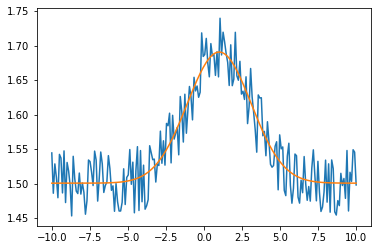

In [6]:
params = {"x": x_space, "y": gauss_data}

gauss_solver = GaussFitSolver(params)
result = gauss_solver.execute(GaussFitRunMode.RUN)

plt.plot(params["x"], params["y"])
plt.plot(params["x"], result);

And we can run the solver in `MOCK` mode:

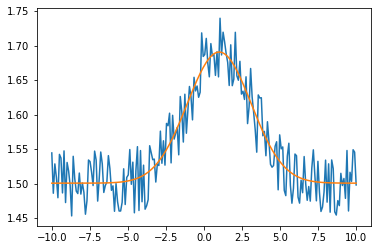

In [7]:
result = gauss_solver.execute(GaussFitRunMode.MOCK)

plt.plot(params["x"], params["y"])
plt.plot(params["x"], result);